In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
from datetime import date, time, timedelta
import datetime as dt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Предобработка данных <a id="start"></a>

Загрузим файлы и проверим правльность данных в них

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
orders = pd.read_csv('/datasets/orders.csv')

In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [5]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [6]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Пропусков нет

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Пропусков в данных нет. Переведем данные столбца date в подходящий формат даты из формата object 

In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [11]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков нет. Переведем данные столбца date в подходящий формат даты из формата object 

In [13]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [14]:
visitors.describe()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


### 1.Приоритизация гипотез.<a id="hypothesis"></a>

### 1.1.Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета<a id="ice"></a>

Reach — скольких пользователей затронет изменение, которое вы хотите внести;
Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
Efforts — сколько стоит протестировать эту гипотезу.

In [15]:
hypothesis['ICE']=(hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

In [16]:
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


In [17]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.333333
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.000000
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.000000
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.333333
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.000000
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.200000
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.200000


Наиболее перспективные гипотезы - 8, 0, 7, 6.

### 1.2.Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета<a id="rice"></a>

In [18]:
hypothesis['RICE']=(hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

In [19]:
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Наиболее перспективные гипотезы - 7, 2, 0, 6.

### 1.3.Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло<a id="icevsrice"></a>

После применения фреймворка RICE на первое место вышла гипотеза №7, так как в этом фреймворке у нас добавляется в числитель параметр Reach (скольких пользователей затронет изменение, которое вы хотите внести) и у гипотезы №7 он равен 10 (максимальное), а у №8 - 1; у гипотез №0 и №6 - 3 и 5, соответственно.

### 2.Анализ A/B-теста<a id="abtest"></a>

### 2.1.Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения<a id="cumrev"></a>

Создадим датафрейм datesGroups с уникальными парами значений 'date' и 'group', таблицы orders. Избавимся от дубликатов методом drop_duplicates()

In [20]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [21]:
datesGroups.head(5)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получаем агрегированные кумулятивные по дням данные о заказах 

In [22]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
ordersAggregated.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

In [24]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [25]:
visitorsAggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия

In [26]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [27]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [28]:
print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

Создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

In [29]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

Создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

In [30]:
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Строим график выручки группы А и грыппы В

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

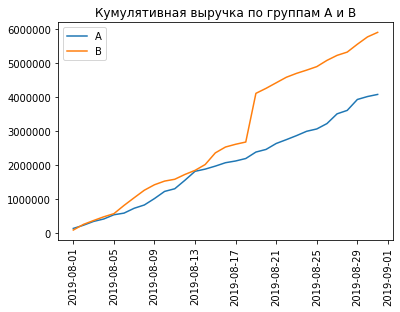

In [31]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title("Кумулятивная выручка по группам А и В")
plt.xticks(rotation=90)

Выручка увеличивается в течение всего теста. На графике выручка группы В резко растет между 17 и 21 августа . Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Выручка группы А растет довольно равномерно, без сильных всплесков

### 2.2.Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения<a id="cumcheck"></a>

Чтобы найти средний чек, надо разделить кумулятивную выручку на кумулятивное число заказов

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

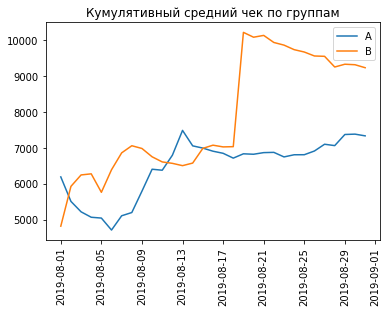

In [32]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title("Кумулятивный средний чек по группам")
plt.xticks(rotation=90)

Средний чек становится равномерным к самому концу теста (примерно к 29 августа). Есть резкий всплекс по среднему чеку в группе В после 17 августа. Возможно, в этот период стало больше заказов или заказы стали дороже.

### 2.3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения<a id="cumcheckchange"></a>

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline()

Соберем данные в одном датафрейме

In [33]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Поcтроим соотношение средних чеков

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

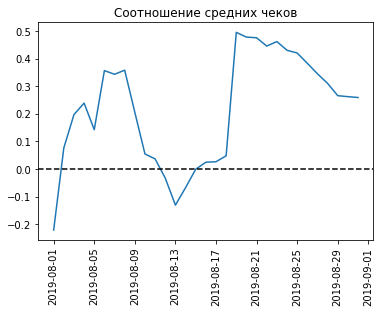

In [34]:
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("Соотношение средних чеков")
plt.xticks(rotation=90)

В нескольких точках есть резкие спады и скачки средних чеков. После 17 августа средний чек группы В стал почти на 50% выше среднего чека группы А. Возможно, это влияние размера заказов ("аномальные заказы". На графике видно, что результаты группы В, хоть и начали снижаться после 21 августа, но все равно, к концу тестового периода,остаются примерно на 25% лучше результатов группы А.

### 2.4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения<a id="cumconversion"></a>

Cчитаем кумулятивную конверсию

In [35]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [36]:
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Отделяем данные по группе A

In [37]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [38]:
cumulativeDataA.head(5)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


Отделяем данные по группе B

In [39]:
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

In [40]:
cumulativeDataB.head(5)

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793


Строим график, используя метод plt.axis(), чтобы задать масштаб осей

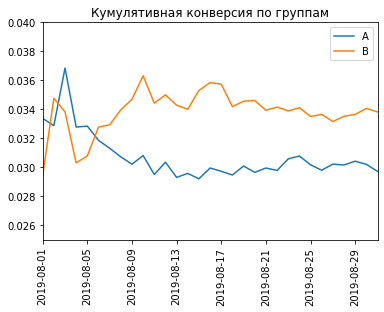

In [41]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title("Кумулятивная конверсия по группам")
plt.axis(["2019-08-01", '2019-08-31', 0.025, 0.04]) 
plt.xticks(rotation=90)
plt.legend()

Получается симметричный график конверсий, до  5 августа группы колебались около одного значения, затем конверсия группы В начала рост и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

### 2.5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения<a id="cumconversionchange"></a>

In [42]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [43]:
mergedCumulativeConversions.head(5)

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


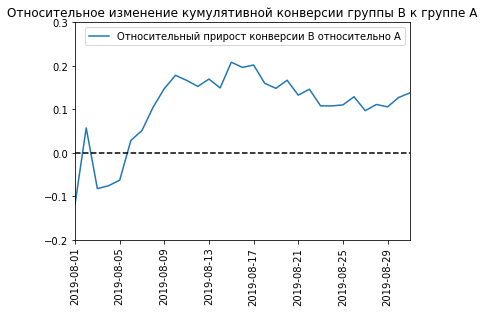

In [44]:
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии B относительно A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.2, 0.3]) 
plt.title("Относительное изменение кумулятивной конверсии группы B к группе A")
plt.xticks(rotation=90)
plt.legend()

Конверсия группы В имеет волнообразный характер, достигает пиков прироста в 20% относительно группы А в первой половине августа, потом колебалась вверх-вниз и зафиксировалась к концу месяца примерно на уровне 10%. Можно говорить о том, что результаты группы В лучше результатов группы А.

### 2.6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения<a id="scatterorder"></a>

Найдем число заказов по пользователям и создадим датафрейм 

In [45]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
)

In [46]:
ordersByUsers.columns = ['userId', 'orders']

In [47]:
display(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Text(0.5, 1.0, 'Точечный график количества заказов по пользователям')

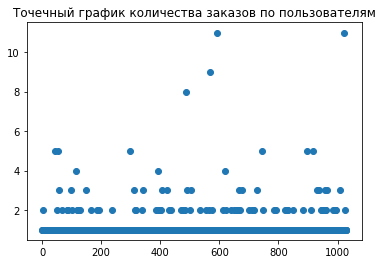

In [48]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title("Точечный график количества заказов по пользователям")

Мало пользователей, которые сделали больше 2 заказов. Оценить аномалия это или нет, можно если рассчитать выборочные перцентили.

### 2.7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей<a id="95orderamount"></a>

In [49]:
print(np.percentile(ordersByUsers['orders'], [ 95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше, чем 2 заказа. 1% пользователей заказывал более 4 раз. 

Выберем 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеем аномальных пользователей по ней. 

### 2.8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения<a id="scatterorderprice"></a>

Text(0.5, 1.0, 'Точечный график стоимости заказов')

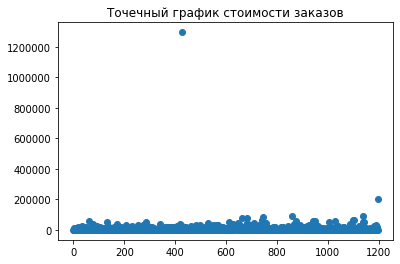

In [50]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title("Точечный график стоимости заказов")

Очень мало заказов дороже 20 000 (только 2 явных выброса). Можем взять 19 000 как границу для аномальных заказов, так как в эту сумму укладывается бОльшая часть совершенных заказов.

### 2.9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов<a id="95orderprice"></a>

In [51]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Не более 5% заказов дороже 28 000  и не более 1% дороже 58 233,2. Возьмем 28 000 как границу для определения аномальных заказов.

### 2.10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения<a id="rawconversion"></a>

По «сырым» данным значит без удаления аномальных пользователей

Подготовим данные

In [52]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]

In [53]:
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [54]:
visitorsADaily.head(5)

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [55]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [56]:
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [57]:
visitorsACummulative.head(5)

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [58]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]

In [59]:
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [60]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)

In [61]:
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [62]:
visitorsBCummulative.head(5)

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [63]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [64]:
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [65]:
ordersADaily.head(5)

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


In [66]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [67]:
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [68]:
ordersACummulative.head(5)

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [69]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

In [70]:
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [71]:
ordersBDaily.head(5)

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [72]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

In [73]:
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [74]:
ordersBCummulative.head(5)

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [75]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [76]:
display(data.head(5)) 

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Смысл переменных:
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в конверсии между группами.

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [77]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [78]:
ordersByUsersA.columns = ['userId', 'orders']

In [79]:
ordersByUsersA.head(5)

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [80]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

In [81]:
ordersByUsersB.columns = ['userId', 'orders'] 

In [82]:
ordersByUsersB.head(5)

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

Переменные должны состоять из двух частей:
Список с количеством заказов для каждого из пользователей.
Нули для пользователей, которые ничего не заказывали. 

In [83]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

0        0
1        0
2        0
3        0
4        0
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18233, dtype: int64

In [84]:
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 498    1
 499    7
 500    1
 501    1
 502    1
 Name: orders, Length: 503, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18228    0
 18229    0
 18230    0
 18231    0
 18232    0
 Name: orders, Length: 18233, dtype: int64]

In [85]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [86]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

Найдем конверсию. В sampleA мы сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Аналогично найдём конверсию группы B: sampleB.mean()

In [87]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [88]:
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Нулевая гипотеза (Н0): конверсия в группе В равна конверсии в группе А. Альтернативная гипотеза (Н1): конверсия в группе В не равна конверсии в группе А.

In [89]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.008


In [90]:
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.138


0.008 меньше 0.05, значит, нулевую гипотезу отвергаем - в конверсии между группами есть статистически значимые различия. Прирост конверсии группы В к группе А равен 13,8%. Вывод: по «сырым» данным различия в конверсии групп A и B есть.

### 2.11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения<a id="rawcheck"></a>

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов, и найдём относительные различия в среднем чеке между группами.

Нулевая гипотеза (Н0): средний чек в группе В равен среднему чеку в группе А. Альтернативная гипотеза (Н1): средний чек в группе В не равен среднему чеку в группе А.

In [91]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.365


In [92]:
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


p-value (0,365) больше 0,05 - статистически значимых различий в среднем чеке между группами нет. Относительное различие среднего чека между группами всего 2,5%. По «сырым» данным различий в среднем чеке групп A и B нет. Надо проанализировать аномалии.

### 2.12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения<a id="refinedconversion"></a>

Ранее мы нашли, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233. 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 19 000 рублей. Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 19 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.Узнаем, сколько всего аномальных пользователей методом shape().

In [93]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)

In [94]:
usersWithExpensiveOrders = orders[orders['revenue'] > 19000]['visitorId']

In [95]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [96]:
display(abnormalUsers.head(5))

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
dtype: int64

In [97]:
display(abnormalUsers.shape) 

(105,)

Всего 105 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [98]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [99]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [100]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.015


p-value увеличился по сравнению с p-value "сырых" данных; но 0,015 меньше 0.05, значит, нулевую гипотезу отвергаем - в конверсии между группами есть статистически значимые различия. 

In [101]:
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.149


Прирост конверсии группы В к группе А равен 14,9%. Вывод: по «очищенным» данным различия в конверсии групп A и B есть. Сегмент В значительно лучше сегмента А.

Ранее, о "сырым" данным мы получили показатели 0,008 и 0,138, соответственно. В целом, результаты по конверсии по "очищенным" данным выше, чем по "сырым", но вывод мы получили тот же - есть статистические различия в конверсиях между группами.

### 2.13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения<a id="refinedcheck"></a>

In [102]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

0.465


In [103]:
print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

-0.029


P-value увеличился (в "сырых" данных был 0,365), но он тоже больше 0,05 - статистически значимых различий в среднем чеке между группами нет. Но средний чек группы B получился ниже среднего чека группы A. Общий вывод по результатам теста не изменился.

##### Общие выводы по сравнению конверсии и среднего чека по "сырым" и "очищенным" данным:

1. Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации аномалий;

2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

3. По графику относительного изменения кумулятивной конверсии группы B к группе A(пункт 2.5.) видим, что конверсия группы В имеет волнообразный характер, достигает пиков прироста в 20% относительно группы А в первой половине августа, потом колебалась вверх-вниз и зафиксировалась к концу месяца примерно на уровне 10%. Можно говорить о том, что результаты группы В лучше результатов группы А.

4. По графику относительного изменения кумулятивного среднего чека группы B к группе A(пункт 2.3.) видим, что В нескольких точках есть резкие спады и скачки средних чеков. После 17 августа средний чек группы В стал почти на 50% выше среднего чека группы А. Возможно, это влияние размера заказов ("аномальные заказы". На графике видно, что результаты группы В, хоть и начали снижаться после 21 августа, но все равно, к концу тестового периода,остаются примерно на 25% лучше результатов группы А.

### 2.14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест<a id="result"></a>

На основании выводов в пункте 2.13. я бы признала тест успешным, зафиксировала победу группы В и остановила бы тест.